In [7]:
from nstep_lstm_using_chainer_with_adding_problem import MyNet
from chainer import serializers
import chainer
import numpy as np
import matplotlib.pyplot as plt 
import _pickle
from params_for_adding_problem import *  # noqa
from make_adding_problem import *
from sklearn.model_selection import train_test_split
from predict_for_adding_problem import *
import random
%matplotlib inline

use gpu


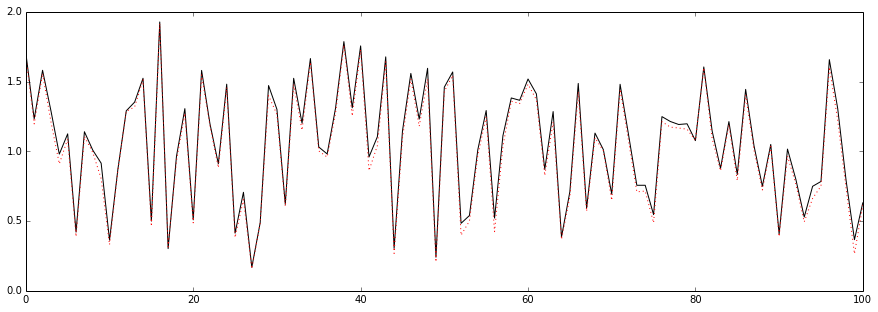

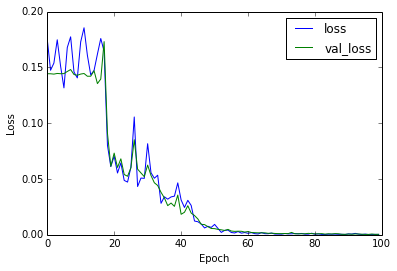

In [29]:
xp = np
if GPU >= 0:
    xp = chainer.cuda.cupy
    # always run the same calcuation
    np.random.seed(SEED)
    print('use gpu')
else:
    print('use cpu')
xp.random.seed(SEED)
random.seed(SEED)
    
# _/_/_/ モデルの 

mynet = MyNet(N_LAYERS, N_IN, N_HIDDEN, N_OUT)
serializers.load_npz('chainer_mynet_dropout={}.npz'.format(DROPOUT), mynet)
if GPU >= 0:
    mynet.to_gpu()

# _/_/_/ データ

data, target = make_adding_problem(TOTAL_SIZE, SEQUENCE_SIZE)
if GPU >= 0:
    data = chainer.cuda.to_gpu(data)
    target = chainer.cuda.to_gpu(target)

assert data.shape == (TOTAL_SIZE, SEQUENCE_SIZE, N_IN)
assert target.shape == (TOTAL_SIZE, N_OUT)

# 訓練データと検証
n_train = int(TOTAL_SIZE * SPRIT_RATE)
n_val = TOTAL_SIZE - n_train
train_x, val_x, train_y, val_y = train_test_split(data, target, test_size=n_val)
assert train_x.shape == (n_train, SEQUENCE_SIZE, N_IN)
assert train_y.shape == (n_train, N_OUT)
assert val_x.shape == (n_val, SEQUENCE_SIZE, N_IN)
assert val_y.shape == (n_val, N_OUT)

# _/_/_/ 予測する。

ys = predict(mynet, val_x)
ys = chainer.cuda.to_cpu(ys.data)
val_y = chainer.cuda.to_cpu(val_y).astype(np.float32)

# 予測したデータと正解データの比較。
plt.figure(figsize=(15, 5))
plt.xlim(0, 100)
plt.plot(val_y, color='black')
plt.plot(ys, linestyle='dotted', color='red')
plt.show()

# _/_/_/ 誤差とエポックの間の関係
losses = _pickle.load(open('./chainer_losses_dropout={}.pkl'.format(DROPOUT), 'rb'))
val_losses = _pickle.load(open('./chainer_val_losses_dropout={}.pkl'.format(DROPOUT), 'rb'))
plt.plot(losses, label='loss')
plt.plot(val_losses, label='val_loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
